In [896]:
from urllib.request import urlopen
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

IPythonConsole.drawOptions.addAtomIndices = True
%matplotlib inline

In [897]:
"""
The following program is a study of the prediction of the potentials of rhenium-bipyridine complexes 
using a machine learning alogorithm. The training data is obtained by (1) randomly generating rhenium-bipyridine 
complexes by modifying the side-chains of the bipyridine using a previously presented program (see my github), 
(2) calculating the redox potential of these complexes in gas phase using the semi-empirical method XTB 
(motivations for the choice of method available elsewhere). The repartition of the overall charge of the molecules in 
the training set were selected in order to have a similar density of training data over a large range of potential. 
In the end, a training set of 537 complexes is obtained.
"""


(array([  4.,   8.,   5., 266.,  88.,  78.,  31.,  45.,   9.,   3.]),
 array([-2.16383707, -0.71361882,  0.73659942,  2.18681766,  3.6370359 ,
         5.08725415,  6.53747239,  7.98769063,  9.43790887, 10.88812711,
        12.33834536]),
 <BarContainer object of 10 artists>)

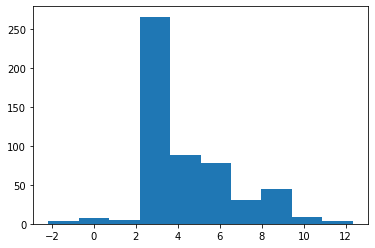

In [898]:
"""
Here, the data is processed in order to remove the Re(bpy)(CO)3 motif from each molecules. This is redundant 
information since only the side-chains of the bipyridines are changing from one complex to the next. Furthermore, 
the data points which calculations have failed are also removed from the set. Those points have unphysically large 
potentials due to failed energy calculations having been arbitrarily set to zero. Hence we constrain the data points 
to a range of potentials, here rather arbitrarily set to [-2.5,12.5].
As we can see on the Histogram below, the largest amount of data points still remains, by far, between +2 and +4.This 
is due to the fact that most neutral sidechains end up in this range of potential rather than anywhere else. 
For further development, the inclusion of more specifically positively charged complexes in the training set could help 
getting a more balanced description of complexes with E > +6 V.
"""

file1 = open('/Users/tarrago/Documents/personal-project/positively-charged/smiles-index-compiled','r')
libsmiles = file1.readlines()
file1.close()
file1 = open('/Users/tarrago/Documents/personal-project/positively-charged/redox-file-compiled','r')
libpot = file1.readlines()
file1.close()
libbipy = []
for i in libsmiles:
    libbipy.append(Chem.MolFromSmiles(i))
sub1 = Chem.MolFromSmiles('[Re](C#[O+])(C#[O+])(C#[O+])')
for i in range(0,len(libbipy)):
    libbipy[i] = AllChem.DeleteSubstructs(libbipy[i],sub1)
for i in range (0,len(libpot)):
    libpot[i] = libpot[i].replace('\n','')
    libpot[i] = float(libpot[i])
destroy = []
for i in range(0,len(libpot)):
    if libpot[i] > 12.5:
        destroy.append(i)
    elif libpot[i] < -2.5:
        destroy.append(i)
i = len(destroy) - 1
while i > -1 :
    libpot.remove(libpot[destroy[i]])
    libbipy.remove(libbipy[destroy[i]])
    i = i - 1
plt.hist(libpot,bins=10)

In [931]:
"""
In the following, I define a number of homebrew function that I built using rd-kit in order to obtain the descriptors
(or features) of the training set. Two different sets of descriptors have been used. Inspired one publication 
(Ind. Eng. Chem. Res. 2017, 56, 4898−4910),
we have taken four different types of autocorrelation functions up to the nth order (see the description in the 
function ACcustom). These AC function can be obtained from RDkit. However, a number of bugs have been reported which
made me nervous. This is why I coded my own. From a different publication (ACS Omega 2018, 3, 7868−7874), we have taken the descriptors 
corresponding to the number of elements with a specific coordination number, as well as the number of rings of a given 
number of atoms. For both sets, we added the overall charge of the complex, which obviously plays a large role in the 
reduction potential. Notably, we also tried to use the Morgan Fingerprints as features, but the results were very 
disappointing and we did not consider these descriptors futher
"""
def matrixbuilder1(libmol, n):

    """
    returns the feature matrix using the first type of descriptors (see above). The matrix is returned under the form 
    of a Pandas DataFrame, although in this specific program the dataframe is immediately converted into a numpy array.
    For general use, I believe it is good practice to have it as a DataFrame, which can be handled easily
    """
    
    descriptorvector=[]
    chargevec=[]
    descriptorname=[]
    for i in range(n+1):
        descriptorname.append('AC electronegativity order '+ str(i))
        descriptorname.append('AC atomic number order '+ str(i))
        descriptorname.append('AC atom coordination number order '+ str(i))
        descriptorname.append('AC identity order '+ str(i))
    for m in libmol:
        vec = ACcustom(m, n)                      # Homebrew function
        descriptorvector.append(vec)
        chargevec.append(Chem.GetFormalCharge(m))
    a = np.array(descriptorvector)
    df = pd.DataFrame(a, columns=descriptorname)
    df['Charge']=chargevec
    df = feature_normalization(df)                # Homebrew function

    return df


def feature_normalization(df):
    
    """
    Normalizes the features using the mean-normalization method. 
    """
    
    for i in df.columns:
        df[i] = (df[i]-df[i].mean()) / (df[i].max()-df[i].min())
    return df
    

def ACcustom(mol,d):
    
    """
    Returns a vector containing the four kinds of autocorrelation functions for the molecule mol up to the order d.
    The four AC function, where AC(d)=Sum over i and j of I(i) * I(j) delta(d(ij)-d) where d(ij) is the number of bonds 
    separating the atoms i and j. The four functions are defined according to the choice of the atomic function I, which
    is here chosen as:
    -> Pauli electronegativity of the atom. 
    -> atomic number. Easy to obtain with the rdkit built-in function.
    -> the atom's coordination number. Easy to obtain with the rdkit function!
    -> the identity, 1.
    In details, the function first writes the 4 AC functions in a (d+1) x 4 matrix, and then unrolls the matrix into a 
    vector. 
    """
    
    AC = []
    ACvec = []
    for i in range(0, d + 1):
        AC.append([0, 0, 0, 0])
    mol = Chem.AddHs(mol)
    distancematrix = distmat(mol)               # Homebrew function
    for i in range(0, len(distancematrix)):
        for j in range(i, len(distancematrix)):
            if distancematrix[i][j] != 'NaN' and distancematrix[i][j] < d+1:
                AC[distancematrix[i][j]][0] = AC[distancematrix[i][j]][0] + fccust(i,mol,'Xpau')*fccust(j,mol,'Xpau')
                AC[distancematrix[i][j]][1] = AC[distancematrix[i][j]][1] + fccust(i,mol,'Z')*fccust(j,mol,'Z')
                AC[distancematrix[i][j]][2] = AC[distancematrix[i][j]][2] + fccust(i,mol,'T')*fccust(j,mol,'T')
                AC[distancematrix[i][j]][3] = AC[distancematrix[i][j]][3] + fccust(i,mol,'I')*fccust(j,mol,'I')

    # fccust is a homebrew function

    for i in range(0, d+1):
        ACvec.append(AC[i][0])
        ACvec.append(AC[i][1])
        ACvec.append(AC[i][2])
        ACvec.append(AC[i][3])

    return ACvec


def distmat(mol):
    
    """
    Returns the NxN distance matrix where N is the number of atoms. each row correpsonds to the number of bonds 
    separating a specific atom from the rest of the atoms in the molecule. Although a bit more redundant than the 
    connection table, I find the distance matrix to be more handy and easy to use for general purposes. 
    In details, the table is generated in two steps: (1) the table is initialized and only the first neighbors positions
    are written in the table. (2) The more distant neighbors are calculated by propagating from neighbor to neighbor for
    each atoms. In the end, the lowest bond number between two atoms is always written in the matrix. 
    """
    
    dmat = []
    Nmol = mol.GetNumAtoms()
    for i in range(0, Nmol):
        dmat.append([])
        for j in range(0, Nmol):
            if type(mol.GetBondBetweenAtoms(i, j)) is Chem.rdchem.Bond:
                dmat[i].append(1)
            elif i == j:
                dmat[i].append(0)
            else:
                dmat[i].append('NaN')
    N=2
    while N<Nmol:
        # This is begging for a vectorized treatment which should be doable with numpy, but this is not our focus here.
        # Note: probably the triple loop can be avoided with the GetNeighbors() function. Let's put a pin in that for 
        # later. 
        for i in range(0, Nmol):
            for j in range(0, Nmol):
                if dmat[i][j] == N-1:
                    for k in range(0, Nmol):
                        if dmat[j][k] == 1 and dmat[i][k] == 'NaN':
                            dmat[i][k]=N
        N=N+1
                            
                 
    return dmat

def fccust(a, mol, funk):
    
    """
    Returns the I(i) term in the autocorrelation function. Can be either four of the previously defined 
    parameters depending on parameter funk. Regardless, fccust is an tomic function which obviously depdns on the 
    atomic index, a.
    """
    
    if funk == 'Xpau':
        Atom = mol.GetAtomWithIdx(a).GetSymbol()
        if Atom == 'Li':
            P = 0.98
        elif Atom == 'H':
            P = 2.2
        elif Atom == 'Be':
            P = 1.57
        elif Atom == 'B':
            P = 2.04
        elif Atom == 'C':
            P = 2.55
        elif Atom == 'N':
            P = 3.04
        elif Atom == 'O':
            P = 3.44
        elif Atom == 'F':
            P = 3.98
        elif Atom == 'Na':
            P = 0.93
        elif Atom == 'Mg':
            P = 1.31
        elif Atom == 'Al':
            P = 1.61
        elif Atom == 'Si':
            P = 1.9
        elif Atom == 'P':
            P = 2.19
        elif Atom == 'S':
            P = 2.58
        elif Atom == 'Cl':
            P = 3.16
        elif Atom == 'Re':
            P = 1.9
        elif Atom == 'Br':
            P = 2.96
        elif Atom == 'I':
            P = 2.66
        else:
            P = 0
    elif funk == 'Z':
        P = mol.GetAtomWithIdx(a).GetAtomicNum()
    elif funk == 'T':
        P = len(mol.GetAtomWithIdx(a).GetNeighbors())
    elif funk == 'I':
        P = 1
    return P


def set_matrix_builder(library):
    
    """
    Returns the feature matrix using the second type of descriptors (see above). The matrix is returned under the form 
    of a Pandas DataFrame. In details, the function builds a matrix of descriptors, and removes the columns where all 
    values are zero. This unfortunately happens due to the way the code was written, some features correspond to highly 
    hypervalent atoms which should not ever happen (no octavalent carbon anytime soon). Such columns are obviously unsignificant and should be discarded.
    """
    
    X = []
    chargevec = []
    for mol in library:
        V = alternative_descriptors_builder(mol)              # Homebrew function
        X.append(V)
        chargevec.append(Chem.GetFormalCharge(mol))
    Xnp = np.array(X)
    column_vector = [
        'C0','C1','C2','C3','C4','C5','C6','C7','C8', 
        'N0','N1','N2','N3','N4','N5','N6','N7','N8', 
        'O0','O1','O2','O3','O4','O5','O6','O7','O8', 
        'F0','F1','F2','F3','F4','F5','F6','F7','F8', 
        'Si0','Si1','Si2','Si3','Si4','Si5','Si6','Si7','Si8', 
        'P0','P1','P2','P3','P4','P5','P6','P7','P8', 
        'S0','S1','S2','S3','S4','S5','S6','S7','S8', 
        'Cl0','Cl1','Cl2','Cl3','Cl4','Cl5','Cl6','Cl7','Cl8',
        'Br0','Br1','Br2','Br3','Br4','Br5','Br6','Br7','Br8',
        'I0','I1','I2','I3','I4','I5','I6','I7','I8',
        'R0','R1','R2','R3','R4','R5','R6','R7','R8',
    ]
    Xdf = pd.DataFrame(Xnp, columns = column_vector)
    Xdf['Charge'] = chargevec
    Boolvec = (Xdf==0).all(axis=0).values
    destroyer = []
    for i in range(0, len(Boolvec)):
        if Boolvec[i] == True:
            destroyer.append(column_vector[i])
    Xdf.drop(labels = destroyer, axis=1, inplace=True)
    Xdf = feature_normalization(Xdf)                          # Homebrew function
    return Xdf


def alternative_descriptors_builder(mol):

    """
    This function returns a vector containing all the features of a given molecule mol as described in ref. XX. 
    First it builds a 11x9 matrix Atoms which rows correspond to the element (C, N, O.. and ring), and in the 
    column the number associated with the element, i.e. the number of neighbors for the atoms (row 0-10) or 
    the number of atoms in the ring (row 11). Each cell of the matrix is therefore a feature. Atoms[0][4],
    for instance, corresponds to the number of  tetravalent carbons in the molecule. Once this matrix is properly 
    filled, it is unrolled into a vector (vec). 
    """
    
    Atoms = []
    for i in range(0, 11):
        Atoms.append([0, 0, 0, 0, 0, 0, 0, 0, 0])
    
    for a in range(0, mol.GetNumAtoms()):
        I = convert_atomstoindex(mol.GetAtomWithIdx(a).GetSymbol())         # homebrew function
        J = len(mol.GetAtomWithIdx(a).GetNeighbors())
        if I != 99 and J < 9:
            Atoms[I][J] = Atoms[I][J]+1
    #Then we can unroll it into a vector
    rnum = ring_generator(mol)                                              # homebrew function
    for i in rnum:
        if i < 9:
            Atoms[10][i] = Atoms[10][i]+1
    vec = []
    for i in range(0,11):
        for j in range(0,9):
            vec.append(Atoms[i][j])
            
    return vec


def convert_atomstoindex(symbol):
    
    """
    Simple function which assigns an index to a symbol, in order to fill the proper cell of the matrix Atoms in 
    the function alternative_descriptors_builder.
    """
    
    indx=99
    if symbol == 'C':
        indx=0
    elif symbol == 'N':
        indx=1
    elif symbol == 'O':
        indx=2
    elif symbol == 'F':
        indx=3
    elif symbol == 'Si':
        indx=4
    elif symbol == 'P':
        indx=5
    elif symbol == 'S':
        indx=6
    elif symbol == 'Cl':
        indx=7
    elif symbol == 'Br':
        indx=8
    elif symbol == 'I':
        indx=9
    return indx


def ring_generator(mol):
    
    """
    returns ring_number, a vector containing the number of atoms present in each ring of the molecule.
    Of note, this algorithm recognizes motifs of several rings sharing more than one bond as rings themselves. 
    Hence, for pyrene for instance, it will count 4 6-atoms ring, two 12-atoms ring and one 14 atom ring. 
    Regardless, it does produce a vector that is quite specific to the number and disposition of the rings within 
    a given molecule, and can act as a type of fingerprint, which makes it a good enough descriptor, at least for 
    the present purpose.
    """
    
    d = distmat(mol)                                    # Homebrew function
    N = mol.GetNumAtoms()
    vecvec = [[0]]
    path = []
    while vecvec != []:
        vecvec = duplicate_path(vecvec, d, N)           # Homebrew function
        path,vecvec = select_path(path, vecvec, d, N)   # Homebrew function
    ring_number = ring_selector(path)                   # Homebrew function

    return ring_number

def duplicate_path(vecvec, d, N):
    
    """
    for a vector containing a list (vecvec) of atom index lists (vecvec[i]), adds to each such list vecvec[i] 
    the index of the atom directly bound to the atom which index is the last item of the list. If there are more 
    than one such atom, instead returns as many lists each containing the indexes in vecvec[i] plus the index of 
    one of the atom's neighbor, unless this neighbor is already present in the penultinmate position of vecvec[i]
    (in order for the chain of atoms to proagate only "forward" along the bonds). 
    """
    
    flag = 'spare'
    vecvecmir = vecvec[:]
    for I in vecvecmir:
        vec = I[:]
        for l in range(0,N):
            vecvec,flag = create_path(vecvec, vec, d, l, flag)      # Homebrew function
        if flag == 'kill':
            vecvec.remove(vec)
    return vecvec

def select_path(path, vecvec, d, N):

    """
    This function has a double role: first it checks whether each list of atom indexes in vecvec contain either a ring
    or an end of chain. If it contains an end of chain, the list of index is removed from vecvec. If it contains
    a ring, it is also removed from vecvec, but it is simultaneously written in the vector path. The function then 
    returns the modified vecvec and path. 
    """
    
    destroyer = []
    for i in vecvec:
        k = i[len(i)-1]
        flag = 'destroy'
        f = i[len(i)-2]
        for l in range(0,N):
            if d[k][l] == 1 and l != f:
                if l in i:
                    flag = 'store'
                    i.append(l)
                    
                elif flag != 'store':
                    flag = 'continue'
        if flag == 'store':
            path.append(i)
            destroyer.append(i)
        elif flag  == 'destroy':
            vecvec.remove(i)
    for i in destroyer:
        vecvec.remove(i)
    return path,vecvec


def ring_selector(path):
    
    """
    For each chains of atoms represented in path, identify the number of atoms in each ring. Then checks eliminates 
    the duplicates of the rings and the ring that include smaller rings already present in path, before removing such 
    duplicates. The last action is needed because two different paths can describe a same ring (one going clockwise and
    the other anticlockwise), or a path may  describe the countour of two rings sharing a bond. 
    """
    
    ring_number = []
    ring_end = []
    for i in path:
        stopflag = 0
        endring = 0
    
        while stopflag == 0:
            if i[endring] == i[len(i)-1]:
                stopflag = 1
                ring_number.append(len(i) - endring - 1)
                ring_end.append(endring)
            else:
                endring = endring + 1
    i = 0
    while i < len(path):
        j = i + 1
        while j < len(path):
            incl = check_inclusion(path[i], path[j], ring_end[i], ring_end[j])
            if incl == True:
                del path[j]
                del ring_number[j]
                del ring_end[j]
            else:
                j = j + 1
        i = i + 1
        
    return ring_number
        

def create_path(vecvec,vec,d,l,flag):
    
    """
    For each atom index lists (vecvec[i]) in a given list (vecvec), creates a new vector vecvec[i+1] 
    containing all indexes of vecvec[i] plus the index of the selected atom of index l, if that atom is 
    bound to the atoms which index is the last item of vecvec[i], AND if that atom is not the penultimate item
    of the list vecvec[i] (prevents the function to "go back" rather than expand the chain of atoms bound to each other).
    Also if one such child vecvec[i+1] is created from the parent vecvec[i], sends the message to remove the parents 
    after all children have been created from it (see function duplicate_path). 
    """
    
    k = vec[len(vec) - 1]
    vecdum = vec[:]
    if d[k][l] == 1:
        if len(vec) == 1:
            flag = 'kill'
            vecdum.append(l)
            vecvec.append(vecdum)
        elif len(vec) > 1 and l != vec[len(vec)-2]:
            vecdum.append(l)
            vecvec.append(vecdum)
            flag = 'kill'
    return vecvec,flag


def check_inclusion(path1,path2,ring_end1,ring_end2):

    """
    The following function eliminates redudant paths, i.e. different paths which describe the same ring.
    """
    
    path1p = path1[ring_end1:]
    path2p = path2[ring_end2:]
    inclusion = True
    for i in path1p:
        if i in path2p:
            continue
        else:
            inclusion = False
            break
    return inclusion

In [905]:
"""
Here we plotted the functions used to compute the performances of a given model (learning curve and cost function)
"""

def learning_curve(model, X_train, X_CV, Y_train, Y_CV, step, plot_flag='no', verb='no'):
    
    """
    Returns the learning curve of the cross-validation subset and that of the training set as well as a list containing 
    the number of training example for each case. 
    """
    
    N = step
    J_train = []
    J_pred = []
    StepVec = []
    while N <= len(X_train):
        X_chunk = X_train[0:N][:]
        Y_chunk = Y_train[0:N]
        gradmodel.fit(X_chunk,Y_chunk)
        Y_trainpredict = gradmodel.predict(X_chunk)
        Y_pred = gradmodel.predict(X_CV)
        J = CostFunction(Y_chunk,Y_trainpredict)
        J_train.append(J)
        J = CostFunction(Y_CV,Y_pred)
        J_pred.append(J)
        StepVec.append(N)
        if verb == 'yes':
            print('Done',str((N/len(X_train))*100)+'%')
        N = N + step
    if plot_flag == 'yes':
        plt.plot(StepVec,J_train)
        plt.plot(StepVec,J_pred)
    
    return J_train, J_pred, StepVec

def CostFunction(Y_set, Y_pred):
    
    """
    Computes the cost function (MSE/2)
    """
    
    J=0
    for i in range(len(Y_set)):
        J = J + (Y_set[i]-Y_pred[i])**2
    J = J / (2*len(Y_set))
    return J

In [930]:
"""
Miscalleneous functions: related to feature selection
"""

def feature_reducer(df, rfecv_model):
    
    """
    After a RFECV optimization, remove the irrelevant features in the corresponding pandas dataframe. 
    """
    
    feature_selector = my_RFECV.get_support()
    column_names = df.columns
    feature_destroyer = []
    df2 = df.copy()
    for i in range(0,len(feature_selector)):
        if feature_selector[i] == False:
            feature_destroyer.append(column_names[i])
    df2.drop(labels=feature_destroyer, axis=1, inplace=True)
    return df2


def AC_choice(library, Y, model, dmax, verbose=0):
    
    """
    Small homebrew function designed to calculate the optimal order for the autocorrelation functions (specifically 
    for the fist type of descriptors). Returns the pandas dataframe containing the optimal number of features,
    a list of the cross-validation error (negative of the MAE) and a list of the corresponding order d.
    """
    
    CV = []
    Nstep = []
    for i in range(dmax + 1):
        if verbose != 0:
            print('order ' + str(i) + '...')
        df1 = matrixbuilder1(library, i)
        X1 = df1.values
        X_train, X_test, Y_train, Y_test = train_test_split(X1, Y, test_size=0.25, random_state=0)
        if verbose != 0:
            print('features established. Now calculating the cross-validation score...')
        scores = cross_val_score(model, X_train, Y_train, cv=5, scoring = 'neg_mean_absolute_error')
        CV.append(sum(scores)/5)
        Nstep.append(i)
    Max = max(CV)
    Max_index = CV.index(Max)
    if verbose != 0:
        print('optimal order found for ' + str(Max_index))
    df1 = matrixbuilder1(library, Max_index)
    return df1, Nstep, CV

In [902]:
"""
The first type of descriptors consists of different autocorrelation functions. In the following, we check the \
optimal value of d, i.e. that which minimizes the cross-validation error. For that we use a wrapper method, a 
homebrew Recursive Feature Elimination. Thus, we have to define our model. In our case, we use a Gradient Boosting 
Regressor, similar to the publication (ACS Omega 2018, 3, 7868−7874).
"""

Y = np.array(libpot)
gradmodel = GradientBoostingRegressor(loss='ls', max_features=4, n_estimators=5000, learning_rate=0.01)
Descriptors_DataFrame1, N, CV = AC_choice(libbipy, Y, gradmodel, 7, verbose=1)

order 0...
features established. Now calculating the cross-validation score...
order 1...
features established. Now calculating the cross-validation score...
order 2...
features established. Now calculating the cross-validation score...
order 3...
features established. Now calculating the cross-validation score...
order 4...
features established. Now calculating the cross-validation score...
order 5...
features established. Now calculating the cross-validation score...
order 6...
features established. Now calculating the cross-validation score...
order 7...
features established. Now calculating the cross-validation score...
optimal order found for 1


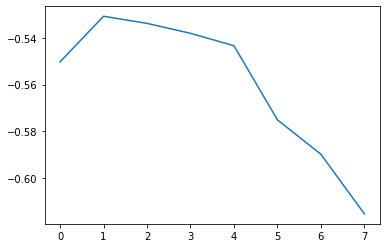

In [906]:
"""
The feature selection algorithm above shows that the optimal order of the AC functions is 1.
"""
plt.plot(N, CV)

In [907]:
"""
Below is shown the first five rows of the feature matrix. According to good practices, we have normalized those 
features by min-max and substracted by the average value of each feature in the training set.
"""

Descriptors_DataFrame1.head()

,AC electronegativity order 0,AC atomic number order 0,AC atom coordination number order 0,AC identity order 0,AC electronegativity order 1,AC atomic number order 1,AC atom coordination number order 1,AC identity order 1,Charge
0,0.060449,0.016771,0.062678,0.063286,0.063268,0.043512,0.059708,0.062455,-0.067349
1,0.223524,0.157417,0.239654,0.246960,0.233091,0.207616,0.217637,0.248169,-0.067349
2,0.014830,-0.030609,0.036905,0.037776,0.018638,-0.011189,0.028520,0.033883,0.099317
3,-0.059430,-0.036989,-0.052442,-0.054061,-0.052780,-0.046228,-0.049118,-0.051831,-0.067349
4,0.121406,0.064015,0.155461,0.150021,0.125999,0.119946,0.155262,0.148169,-0.067349


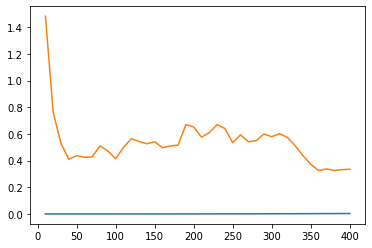

In [918]:
"""
Now using scikit-learn, we divide the data into a training set and cross-validation test, fit a Gradient Boosting 
Regressor model to our data, and plot the associated learning curve on the test set (yellow)
and on the training set (blue). 
"""
X1 = Descriptors_DataFrame1.values
Y = np.array(libpot)
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y, test_size=0.25, random_state=1)
gradmodel = GradientBoostingRegressor(loss='ls', max_features=4, n_estimators=5000, learning_rate=0.01)
gradmodel.fit(X_train,Y_train)
Y_inboxpred = gradmodel.predict(X_train)
Y_pred = gradmodel.predict(X_test)
j_train, j_pred, stepvector = learning_curve(gradmodel, X_train, X_test, Y_train, Y_test, 10, plot_flag = 'yes')

0.3535612015366016 0.0028773693094332224


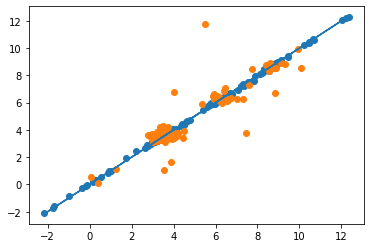

In [919]:
"""
Here is plotted the associated "experimental" vs. predicted curve. The cost function mean_squared error is about 0.353 on the test set and
0.0029 on the training set, which demonstrates an overfit.
"""
plt.scatter(Y_train,Y_inboxpred)
plt.plot(Y_train,Y_train)
plt.scatter(Y_test,Y_pred)
J_test = CostFunction(Y_test, Y_pred)
J_train = CostFunction(Y_train, Y_inboxpred)
print(J_test, J_train)

In [920]:
"""
Clearly, the situation resembles a high-variance case. 
It seems our case would benefit from increasing the number of data points, and/or try to reduce the number of features.
Here we use a recursive feature elimination algorithm with cross-validation, as implemented in scikit-learn.
"""
my_RFECV = RFECV(
    estimator=gradmodel, step=1, min_features_to_select=4, cv=5, scoring=None, verbose=0, n_jobs=None, 
    importance_getter='auto'
)
my_RFECV.fit(X_train,Y_train)
print(my_RFECV.get_support())

[ True  True  True  True  True  True  True  True  True]


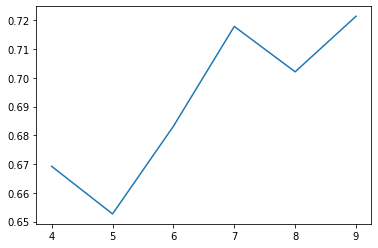

In [922]:
"""
If we take a look at the Gini impurity-derived feature importance vs number of features curve, 
it appears that a maximum is reached for 9 features. Hence the data frame is not modified.
"""
plt.plot(range(4,len(my_RFECV.grid_scores_) + 4), my_RFECV.grid_scores_)


In [924]:
"""
Here we use an alternative set of descriptors taken from another publication (ACS Omega 2018, 3, 7868−7874).
"""

Descriptors_DataFrame2=set_matrix_builder(libbipy)
Descriptors_DataFrame2.head()

,C1,C2,C3,C4,N1,N2,N3,N4,O1,O2,...,S4,Cl1,Br1,I1,R3,R5,R6,R7,R8,Charge
0,0.269886,-0.029853,0.009650,0.106861,-0.035382,0.022657,0.369957,-0.027933,0.057462,0.066418,...,-0.010242,-0.029795,-0.017225,-0.003724,-0.005587,0.077514,0.010835,-0.003724,-0.014277,-0.067349
1,0.484171,0.048272,0.433892,-0.046985,-0.035382,-0.060677,0.036623,-0.027933,-0.013966,0.333085,...,-0.010242,-0.029795,-0.017225,-0.003724,-0.005587,-0.047486,0.374471,-0.003724,-0.014277,-0.067349
2,0.484171,-0.123603,0.100559,0.029938,-0.035382,-0.060677,0.036623,-0.027933,-0.013966,-0.066915,...,-0.010242,-0.029795,-0.017225,-0.003724,-0.005587,-0.047486,0.010835,-0.003724,-0.014277,0.099317
3,-0.158686,0.001397,-0.050956,-0.046985,-0.035382,0.105990,-0.130043,-0.027933,-0.085395,-0.066915,...,-0.010242,-0.029795,-0.017225,-0.003724,-0.005587,-0.047486,0.010835,-0.003724,-0.014277,-0.067349
4,0.055600,0.126397,0.100559,-0.046985,-0.035382,0.022657,-0.130043,-0.027933,-0.013966,0.133085,...,-0.010242,-0.029795,-0.017225,-0.003724,-0.005587,-0.047486,0.192653,-0.003724,-0.014277,-0.067349


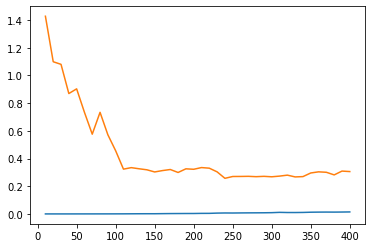

In [925]:
"""
We can then fit our GBR model to this training set. 
"""

X2 = Descriptors_DataFrame2.values
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.25, random_state=1)
gradmodel = GradientBoostingRegressor(loss='ls', max_features=4, n_estimators=5000, learning_rate=0.01)
gradmodel.fit(X_train,Y_train)
Y_inboxpred = gradmodel.predict(X_train)
Y_pred = gradmodel.predict(X_test)
j_train, j_pred, stepvector = learning_curve(gradmodel, X_train, X_test, Y_train, Y_test, 10, plot_flag = 'yes')

0.2968882689217626 0.015003713944726188


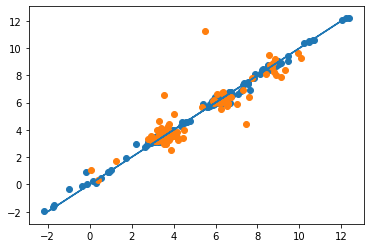

In [926]:
plt.scatter(Y_train,Y_inboxpred)
plt.plot(Y_train,Y_train)
plt.scatter(Y_test,Y_pred)
J_test = CostFunction(Y_test, Y_pred)
J_train = CostFunction(Y_train, Y_inboxpred)
print(J_test, J_train)

[ True  True  True  True  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True False  True False  True  True
  True False  True  True]


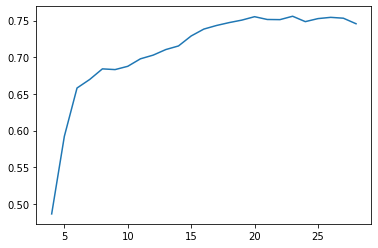

In [927]:
"""
Unsurprisingly, we observe a high variance situation, similar to the previous case. We thus use the same RFECV 
procedure as before... The RFECV leads to the elimination of five features, but the score variation is limited.
"""

my_RFECV.fit(X_train, Y_train)
print(my_RFECV.get_support())
plt.plot(range(4,len(my_RFECV.grid_scores_) + 4),my_RFECV.grid_scores_)

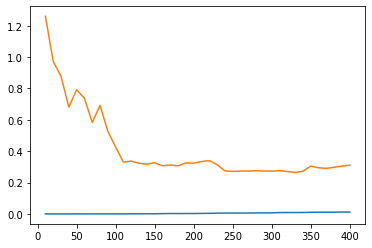

In [928]:
"""
Here is the corresponding learning curve.
"""

Descriptors_DataFrame2_reduced = feature_reducer(Descriptors_DataFrame2, my_RFECV)
X2_reduced = Descriptors_DataFrame2_reduced.values
X_train, X_test, Y_train, Y_test = train_test_split(X2_reduced, Y, test_size=0.25, random_state=1)
gradmodel = GradientBoostingRegressor(loss='ls', max_features=4, n_estimators=5000, learning_rate=0.01)
gradmodel.fit(X_train, Y_train)
Y_inboxpred = gradmodel.predict(X_train)
Y_pred = gradmodel.predict(X_test)
j_train, j_pred, stepvector = learning_curve(gradmodel, X_train, X_test, Y_train, Y_test, 10, plot_flag='yes')

0.3246246060324998 0.014187949571784464


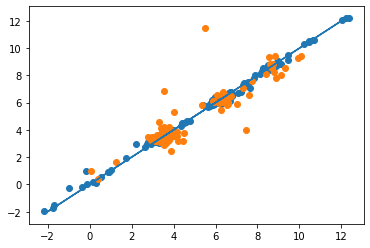

In [929]:
"""
Here the removal of this one feature unsurprisingly does not lead to a better description. 

""" 

plt.scatter(Y_train,Y_inboxpred)
plt.plot(Y_train,Y_train)
plt.scatter(Y_test,Y_pred)
J_test = CostFunction(Y_test, Y_pred)
J_train = CostFunction(Y_train, Y_inboxpred)
print(J_test, J_train)
#plt.plot(Y_test,Y_test)

In [895]:
"""
It seems the best set of feature is the second set (non-reduced). 
Of course, improvement of this model remains possible: 
- As always, finding better features are likely to help the predicting capability of this model. Arguably, if the 
number of datapoints is sufficiently high, descriptors such as circular fingerprints might perhaps yield good 
performance, but given the present number of data points, the use of such a large number of descriptors is not a good 
idea.
- Getting more datapoints, and perhaps more importantly, well balanced datapoints, are likely to improve the performances 
of this model.

We will keep updating this model to improve its accuracy.
"""
